# Imports


In [3]:
from src.convfacenet_train import data_load,models_train,utils,generate_dataset,evaluation
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.convfacenet import face_descriptor
from torchvision import transforms
import pandas as pd
import time


In [4]:
dataset_path = "../dataset/preprocessed/img_celeb_full"
model_weights_path="../model_weights/convnext_tiny"
train_data_save_path="../training log/convnext"
lfw_dataset_path="../dataset/preprocessed/lfw_prep"
img_celeb_subset="../dataset/preprocessed/img_celeb_test"
batch_size=8
stop_n_layers=5

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [5]:
train_history=pd.read_csv(train_data_save_path+"/train_data.csv",index_col=False)

In [6]:
train_history

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,1.010731,1000,0.993768,500,4.5,descriptor without input standardization class...,03/06/2022,16:42:00
1,1.010334,1000,0.995591,500,4.5,descriptor without input standardization class...,03/06/2022,16:46:00
2,1.014047,1000,0.988849,500,4.5,descriptor without input standardization class...,03/06/2022,16:51:00
3,1.011530,1000,0.999809,500,4.5,descriptor without input standardization class...,03/06/2022,16:55:00
4,1.006939,1000,0.999730,500,6.0,descriptor without input standardization class...,03/06/2022,17:01:00
...,...,...,...,...,...,...,...,...
280,0.277700,10000,0.052551,5000,50.6,descriptor hard negative selection from 10 not...,13/06/2022,06:57:00
281,0.278854,10000,0.041266,5000,51.9,descriptor hard negative selection from 10 not...,13/06/2022,07:49:00
282,0.276347,10000,0.049603,5000,51.5,descriptor hard negative selection from 10 not...,13/06/2022,08:41:00
283,0.270502,10000,0.040039,5000,50.7,descriptor hard negative selection from 10 not...,13/06/2022,09:31:00


# Face descriptor model train

In [65]:
train_dataset = data_load.FacesTripletDataset(f"{dataset_path}/train", 5000, train_transform,load_imgs_from_dict=False)
test_dataset=data_load.FacesTripletDataset(f"{dataset_path}/test", 2500, test_transform,False)


In [66]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:

face_descriptor_model=face_descriptor.FaceDescriptorModel()
face_descriptor_model.load_local_weights(utils.get_last_weights_path(model_weights_path))

In [19]:
face_descriptor_model=face_descriptor.FaceDescriptorModel()
face_descriptor_model.load_local_weights(utils.get_last_weights_path(model_weights_path))


In [20]:
face_descriptor_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=128, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2230520248413086


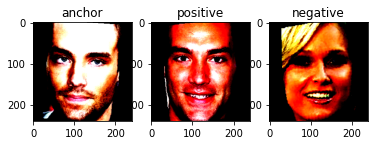

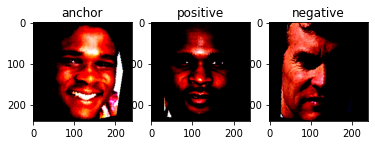

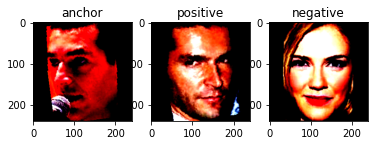

In [67]:
ts=time.time()
a_batch, p_batch, n_batch = next(iter(train_loader))
print(time.time()-ts)
for i in range(3):
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title("anchor")
    ax[0].imshow(a_batch[i].numpy().transpose([1,2,0]))


    ax[1].set_title("positive")
    ax[1].imshow(p_batch[i].numpy().transpose([1,2,0]))



    ax[2].set_title("negative")
    ax[2].imshow(n_batch[i].numpy().transpose([1,2,0]))



In [13]:
for i in range (len(face_descriptor_model.features)):
      for parm in face_descriptor_model.features[i].parameters():
            parm.requires_grad=True

In [22]:
for i in range(stop_n_layers):
  for parm in face_descriptor_model.features[i].parameters():
    parm.requires_grad=False


In [10]:
for parm in face_descriptor_model.parameters():
    parm.requires_grad=True

In [26]:
face_descriptor_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.35, inplace=False)
  (3): Linear(in_features=768, out_features=256, bias=True)
)

## Descriptor Random anchor negative selection

In [23]:
epochs=15
learning_rate=0.00001
train_notes="descriptor with  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225] classifier (768,256)"


In [24]:
train_losses=models_train.model_train(face_descriptor_model,epochs=15,learn_rate=0.00001,train_loader=train_loader,test_loader=test_loader,train_mod="triplet",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

Testing before training ...
 Testing  [==========] time taken (m) = 1.801401 Avg Test_Loss=0.0595219712Test Loss before Training=0.05961648559570312
-----------------------------------------------------
 epoch 1 [==========] time Taken (git m) = 7.222138 Avg Train_Loss=0.117005
mean of unique pictures usage count = 1.807 and std = 1.922 , no of unique pictures used =91875
 Testing  [==========] time taken (m) = 1.791488 Avg Test_Loss=0.0523692537 epoch 1 train_loss =0.1170054539680481 test_loss=0.05245314044952393
new minimum test loss 0.052453  achieved, model weights saved 
-----------------------------------------------------
 epoch 2 [==========] time Taken (git m) = 7.223016 Avg Train_Loss=0.110924
mean of unique pictures usage count = 1.882 and std = 2.167 , no of unique pictures used =96199
 Testing  [==========] time taken (m) = 1.791807 Avg Test_Loss=0.0496439652 epoch 2 train_loss =0.11092490615844726 test_loss=0.04972331619262695
new minimum test loss 0.049723  achieved, mod

## Descriptor Hard anchor negative selection

In [52]:

face_descriptor_model=face_descriptor.FaceDescriptorModel()
face_descriptor_model.load_local_weights(utils.get_last_weights_path(model_weights_path))


In [23]:
face_descriptor_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=128, bias=True)
)

In [8]:
img_features=None
stop_n_layers=5

In [24]:
import torch.nn as nn
models_train.model_test(model=face_descriptor_model,test_loader=test_loader,loss_function=nn.TripletMarginLoss(),test_mod="triplet",cuda=True)

 Testing  [==========] time taken (m) = 1.950635 Avg Test_Loss=0.0549355111

0.05502334232330322

In [39]:
for param in face_descriptor_model.features.parameters():
    param.requires_grad=False

In [40]:
face_descriptor_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
)

In [42]:
import torch
epochs=25
learning_rate=0.00001
train_notes="descriptor hard negative selection from 10 not 5 , starting with test 0.2 loss calculation fixed"


In [43]:
optimizer=torch.optim.Adam(params=face_descriptor_model.parameters(),lr=learning_rate)


In [9]:
img_features=None

In [10]:
train_dataset = data_load.FacesHardTripletDataset(face_descriptor_model,True,f"{dataset_path}/train", 10000, train_transform,load_imgs_from_dict=False,img_features_dict=img_features,select_from_negative_cnt=50)
test_dataset=data_load.FacesTripletDataset(f"{dataset_path}/test", 5000, test_transform,False)

 data processed [==========] time remaing=-0.00


In [45]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
train_losses=models_train.model_train(face_descriptor_model,epochs=epochs,learn_rate=learning_rate,train_loader=train_loader,test_loader=test_loader,train_mod="triplet",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes,optimizer=optimizer)

In [37]:
face_descriptor_model.save_weights("_0.028_loss.pt")

# Face descriptor evaluation

In [53]:
# face_descriptor_model.load_local_weights(get_last_weights_path(model_weights_path))
face_descriptor_model.load_local_weights('../model_weights/convnext_tiny/06_12 21_44 Train_(0.309603) Test_(0.045603).pt')


## ImgCelbA

In [8]:
img_celeb_features_dict=utils.load_dict_from_json("face_features_test_imgcelba.json")


In [26]:
img_celeb_features_dict=data_load.get_pic_features_dict(dataset_path+"/test",face_descriptor_model,test_transform,cuda=True,batch_size=10)

 data processed [==========] time remaing=-0.00


In [28]:
utils.save_dict_to_json("face_features_test_imgcelba.json",img_celeb_features_dict)

In [9]:
test_data_pd_full=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(dataset_path+'/test',False))

In [24]:
full_test_data_pd = test_data_pd_full.sample(frac=1)
test_data_pd = full_test_data_pd

### Euclidean distance

In [25]:
error_table,confusion_matrix=evaluation.model_test(img_celeb_features_dict, test_data_pd, results_path="",distance_method=utils.euclidean_distance ,threshold=8.5)

 Testing  [==========] time remaining = 0.0 Accuracy =93.909Accuracy now equal --> 93.9085%


In [26]:
error_table

,Mertic,Value
0,processed rows,1090258.000
1,Model accuracy on Proceed Faces %,93.910
2,False Positive,21713.000
3,False Negative,44700.000
4,precision,0.958
5,recall,0.918
6,fbeta-score,0.938
7,avg same person distance,6.572
8,avg diff person distance,11.552
9,Model tolerance,8.500


In [29]:
confusion_matrix

,Actual True,Actual False
Predicted True,500429,21713
Predicted False,44700,523416


### cosine distance
- cosine distance=1-cosine similarity

In [46]:
full_test_data_pd = test_data_pd_full.sample(frac=1)
test_data_pd = full_test_data_pd

In [47]:
error_table, confusion_matrix = evaluation.model_test(img_celeb_features_dict, test_data_pd, results_path="",
                                                      distance_method=utils.findCosineDistance, threshold=0.42)

 Testing  [==========] time remaining = 0.0 Accuracy =92.149Accuracy now equal --> 92.1493%


In [48]:
error_table

,Mertic,Value
0,processed rows,1090258.000
1,Model accuracy on Proceed Faces %,92.150
2,False Positive,21739.000
3,False Negative,63854.000
4,precision,0.957
5,recall,0.883
6,fbeta-score,0.918
7,avg same person distance,0.269
8,avg diff person distance,0.801
9,Model tolerance,0.420


In [50]:
confusion_matrix

,Actual True,Actual False
Predicted True,481275,21739
Predicted False,63854,523390


## Labled Faces in the Wild

In [ ]:
lfw_features_dict=utils.load_dict_from_json("face_features_lfw.json")


In [55]:
eval_transform = transforms.Compose([transforms.Resize((240,240)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

### Euclidean distance

In [56]:
lfw_features_dict = data_load.get_pic_features_dict(lfw_dataset_path, face_descriptor_model, eval_transform,
                                                cuda=True, batch_size=10)


 data processed [==========] time remaing=-0.00


In [57]:
utils.save_dict_to_json("face_features_lfw.json",lfw_features_dict)


In [58]:
test_lfw_data_pd_full = pd.DataFrame(generate_dataset.generate_testing_data_set_frame(lfw_dataset_path, True))


In [60]:
full_test_lfw_data_pd = test_lfw_data_pd_full.sample(frac=1)
test_data_lfw_pd = full_test_lfw_data_pd

In [61]:
error_table, confusion_matrix = evaluation.model_test(lfw_features_dict, test_data_lfw_pd, results_path="", threshold=7.65)


 Testing  [==========] time remaining = 0.0 Accuracy =95.799Accuracy now equal --> 95.7988%


In [29]:
error_table

,Mertic,Value
0,processed rows,484414.000
1,Model accuracy on Proceed Faces %,95.820
2,False Positive,10364.000
3,False Negative,9873.000
4,precision,0.957
5,recall,0.959
6,fbeta-score,0.958
7,avg same person distance,5.998
8,avg diff person distance,10.303
9,Model tolerance,7.650


### cosine distance
- cosine distance=1-cosine similarity

In [58]:
test_lfw_data_pd_full = pd.DataFrame(generate_dataset.generate_testing_data_set_frame(lfw_dataset_path, True))


In [85]:
full_test_lfw_data_pd = test_lfw_data_pd_full.sample(frac=1)
test_data_lfw_pd = full_test_lfw_data_pd

In [86]:
error_table, confusion_matrix = evaluation.model_test(lfw_features_dict, test_data_lfw_pd, results_path="",
                                                      distance_method=utils.findCosineDistance, threshold=0.34)

 Testing  [==========] time remaining = 0.0 Accuracy =95.074Accuracy now equal --> 95.0738%


In [84]:
error_table

,Mertic,Value
0,processed rows,10000.000
1,Model accuracy on Proceed Faces %,95.150
2,False Positive,203.000
3,False Negative,282.000
4,precision,0.958
5,recall,0.943
6,fbeta-score,0.951
7,avg same person distance,0.214
8,avg diff person distance,0.659
9,Model tolerance,0.340


In [87]:
confusion_matrix

,Actual True,Actual False
Predicted True,228773,10429
Predicted False,13434,231778


# conv-Facenet classifier model train (testing only)
- the trained descriptor + classifier
- trying to increase accuracy by using classifier instead of euclidean distance or cosine distance
- also i will try here to increase accuracy by including face landmarks (eye pos , face borders  coordinates ) in the classifer

In [4]:
# descriptor_weights="../model_weights/training/05_26 18_02 Train_(0.022302) Test_(0.018650).pt"
descriptor_weights="../model_weights/convnext_tiny/07_01 14_53 Train_(0.080545) Test_(0.045759).pt"
effnet_weights_path="../model_weights/classifier"

In [ ]:
pair_train_dataset=data_load.FacesHardTripletDataset(f"{dataset_path}/train",10000,train_transform)
pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",5000,test_transform)

In [ ]:
pair_train_loader=DataLoader(pair_train_dataset,8,shuffle=False)
pair_test_loader=DataLoader(pair_test_dataset,8,shuffle=False)

In [8]:
efficient_facenet=face_descriptor.FacenetClassifier(256)
efficient_facenet.cuda()
efficient_facenet.load_local_weights(utils.get_last_weights_path(effnet_weights_path))


In [18]:

img_features = None
train_dataset = data_load.FacesHardTripletDataset(efficient_facenet.descriptor, True, f"{dataset_path}/train", 10000,
                                                  train_transform, load_imgs_from_dict=False,
                                                  img_features_dict=img_features, select_from_negative_cnt=50)
test_dataset = data_load.FacesTripletDataset(f"{dataset_path}/test", 5000, test_transform, False)


 data processed [==========] time remaing=-0.00


In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
efficient_facenet.classifier

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=1, bias=True)
  (4): Sigmoid()
)

In [32]:
for i in range(4):
    for param in efficient_facenet.descriptor.features[i]:
        param.requires_grad=False

In [53]:
for param in efficient_facenet.parameters():
    param.requires_grad=True

In [20]:
for param in efficient_facenet.descriptor.parameters():
    param.requires_grad=False

In [21]:
train_notes=" facenet classifier with convnext backens descriptor train classifier only (256,128),Relu,(128.1) , Sigmoid dec learn rate to 0.0001 Hard Triplet Train"
model_weights_path="../model_weights/classifier"
train_data_save_path="../training log/classifier/convnext"

In [16]:
efficient_facenet.descriptor.load_local_weights("../model_weights/convnext_tiny/06_06 12_02 Train_(0.239315) Test_(0.055797).pt")

In [9]:
efficient_facenet.descriptor.load_local_weights(descriptor_weights)

In [22]:
from torch.optim import Adam
optimizer = Adam(efficient_facenet.parameters(), lr=0.0001)

In [12]:
train_dataset.no_of_rows=100
test_dataset.no_of_rows=100


In [24]:
models_train.model_train(efficient_facenet,100,0.1,train_loader,test_loader,"pair",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes,optimizer=optimizer)

Testing before training ...
 Testing  [==========] time taken (m) = 4.627585 Avg Test_Loss=0.5734333079Test Loss before Training=0.5743512360572814
-----------------------------------------------------
 data processed [==========] time remaing=-0.00
 epoch 1 [==========] time Taken (git m) = 9.314739 Avg Train_Loss=1.288029
mean of unique pictures usage count = 1.539 and std = 0.934 , no of unique pictures used =77987
 Testing  [==========] time taken (m) = 4.580849 Avg Test_Loss=0.5647295265 epoch 1 train_loss =1.2880298742294312 test_loss=0.56563311252594
new minimum test loss 0.565633  achieved, model weights saved 
-----------------------------------------------------
 data processed [==========] time remaing=-0.00
 epoch 2 [==========] time Taken (git m) = 9.318509 Avg Train_Loss=1.274474
mean of unique pictures usage count = 1.687 and std = 1.308 , no of unique pictures used =88912
 Testing  [==========] time taken (m) = 4.594837 Avg Test_Loss=0.5666285141 epoch 2 train_loss =1.2

KeyboardInterrupt: 

In [11]:
efficient_facenet.load_local_weights(utils.get_last_weights_path(effnet_weights_path),True)

In [41]:
celeb_subset_data_path="../dataset/preprocessed/img_celeb_full/test"
imgs_features_dict=data_load.get_pic_features_dict(celeb_subset_data_path,model=efficient_facenet.descriptor,transform=test_transform,cuda=True,batch_size=10)

 data processed [==========] time remaing=-0.00


In [48]:

imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [ ]:
imgs_features_dict=features_dict

In [15]:
utils.save_dict_to_json("lfw_face_features.json",imgs_features_dict)


In [11]:
imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [42]:
full_test_data_pd=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(img_celeb_subset,False))

In [14]:
efficient_facenet.cuda()

EfficientFacenet(
  (descriptor): FaceDescriptorModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU()
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,),

In [43]:
full_test_data_pd=full_test_data_pd.sample(frac=1)
test_data_pd=full_test_data_pd

In [44]:
error_table, confusion_table=evaluation.model_test(imgs_features_dict,test_data_pd,results_path="",threshold=0.65,classifier=efficient_facenet.classify_face_features,cuda=True)

 Testing  [==========] time remaining = 0.0 Accuracy =92.311Accuracy now equal --> 92.3114%


In [45]:
error_table

,Mertic,Value
0,processed rows,399058.000
1,Model accuracy on Proceed Faces %,92.310
2,False Positive,15996.000
3,False Negative,14686.000
4,precision,0.920
5,recall,0.926
6,fbeta-score,0.923
7,avg same person distance,0.878
8,avg diff person distance,0.139
9,Model tolerance,0.650


In [75]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,85.29
2,False Positive,765
3,False Negative,706
4,precision,0.850186
5,recall,0.860111
6,fbeta-score,0.441012
7,avg same person distance,[0.77617145]
8,avg diff person distance,[0.28642783]
9,Model tolerance,0.65


In [68]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,85.59
2,False Positive,923
3,False Negative,518
4,precision,0.829079
5,recall,0.896221
6,fbeta-score,0.44155
7,avg same person distance,[0.7575226]
8,avg diff person distance,[0.28016078]
9,Model tolerance,0.57


In [85]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,86.31
2,False Positive,848
3,False Negative,521
4,precision,0.840653
5,recall,0.895621
6,fbeta-score,0.446928
7,avg same person distance,[0.76668626]
8,avg diff person distance,[0.22067705]
9,Model tolerance,0.56


In [86]:
confusion_table

,Actual True,Actual False
Predicted True,4479,848
Predicted False,521,4152


In [34]:
test_data_pd.head()

,0,1,2
0,9236/042921.jpg,9236/052346.jpg,1
1,9236/042921.jpg,8647/101929.jpg,0
2,9236/042921.jpg,9236/071430.jpg,1
3,9236/042921.jpg,281/129193.jpg,0
4,9236/042921.jpg,9236/082375.jpg,1


In [72]:
efficient_facenet.cpu()

EfficientFacenet(
  (descriptor): FaceDescriptorModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [39]:
s=77
e=100

In [ ]:
for idx in range(s,e):
    face_x_path,face_y_path=f"{dataset_path}/test/{test_data_pd.iloc[idx][0]}",f"{dataset_path}/test/{test_data_pd.iloc[idx][1]}"
    label=test_data_pd.iloc[idx][2]

    face_x_img,face_y_img=data_load.load_image(face_x_path,test_transform,True),data_load.load_image(face_y_path,test_transform,True)
    pred=efficient_facenet.identify_faces(face_x_img,face_y_img)

    print(f"predicted Value={pred} actual={label}")

tensor([[0.8023]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08477306365966797
predicted Value=tensor([0.9411]) actual=tensor([1.])


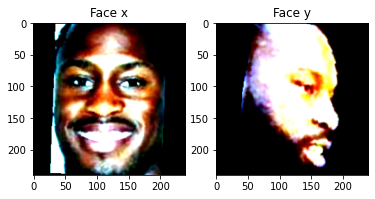

In [73]:
import time
ts=time.time()
face_x_img, face_y_img, label = next(iter(pair_test_loader))
print(time.time()-ts)
i=6
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Face x")
ax[0].imshow(face_x_img[i].numpy().transpose([1,2,0]))


ax[1].set_title("Face y")
ax[1].imshow(face_y_img[i].numpy().transpose([1,2,0]))

pred=efficient_facenet.identify_faces(face_x_img,face_y_img)
print(f"predicted Value={pred[i]} actual={label[i]}")




## EfficentNet Hard anchor negative selection

In [8]:
train_notes=" facenet classifier Hard pair training with convnext backens descriptor train classifier only (256,128),Relu,(128.1) , Sigmoid dec learn rate to 0.0001"
model_weights_path="../model_weights/classifier"

In [9]:
pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",10000,train_transform)
pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",5000,test_transform)

In [32]:
pair_train_loader=DataLoader(pair_train_dataset,16,shuffle=False)
pair_test_loader=DataLoader(pair_test_dataset,16,shuffle=False)

In [31]:
efficient_facenet=face_descriptor.EfficientFacenet(128)
efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)
for i in range(0):
    for param in efficient_facenet.descriptor.features[i]:
        param.requires_grad=False

In [35]:

train_losses = models_train.model_train(efficient_facenet, epochs=1, learn_rate=0.001,
                                            train_loader=pair_train_loader, test_loader=pair_test_loader, train_mod="pair",
                                            cuda=True, weight_saving_path=model_weights_path,
                                            epoch_data_saving_path=train_data_save_path, notes=train_notes,
                                            )


Testing before training ...
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.029022Test Loss before Training=0.029255083046853543
 epoch 1 [=======...] time remaining = 1.284648 Avg Train_Loss=0.051285

KeyboardInterrupt: 

In [ ]:

efficient_facenet=face_descriptor.EfficientFacenet(128)
efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)
img_features = None
import torch
update_features_every_epochs = 10
epochs = 50
learning_rate = 0.0001
optimizer = torch.optim.Adam(params=efficient_facenet.parameters(), lr=learning_rate)

for i in range(int(epochs / update_features_every_epochs)):
    if img_features is None:
        img_features = data_load.get_pic_features_dict(dataset_path + "/train", model=efficient_facenet.descriptor, transform=test_transform,cuda=True,batch_size=10)
    pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",5000,train_transform,load_imgs_from_dict=False, img_features_dict=img_features,
                                                  select_from_negative_cnt=5)
    pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",1000,test_transform)


    pair_train_loader=DataLoader(pair_train_dataset,12,shuffle=False)
    pair_test_loader=DataLoader(pair_test_dataset,12,shuffle=False)

    train_losses = models_train.model_train(efficient_facenet, epochs=update_features_every_epochs, learn_rate=0.001,
                                            train_loader=pair_train_loader, test_loader=pair_test_loader, train_mod="pair",
                                            cuda=True, weight_saving_path=model_weights_path,
                                            epoch_data_saving_path=train_data_save_path, notes=train_notes,
                                            optimizer=optimizer)
    img_features = None
    efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)


 epoch 2 [==========] time remaining = 0.0 Avg Train_Loss=0.05028350309
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03464334532
 epoch 2 train_loss =0.05032330514192581 test_loss=0.03492090210318565
 epoch 3 [==========] time remaining = 0.0 Avg Train_Loss=0.04984849823
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03135731285
 epoch 3 train_loss =0.049888686388731 test_loss=0.03160853345692158
 epoch 4 [==========] time remaining = 0.0 Avg Train_Loss=0.04873048692
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03254032692
 epoch 4 train_loss =0.04876924257278442 test_loss=0.03280064143240452
 epoch 5 [==========] time remaining = 0.0 Avg Train_Loss=0.04859248538
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03276532811
 epoch 5 train_loss =0.04863095901012421 test_loss=0.03302793485671282
 epoch 6 [==========] time remaining = 0.0 Avg Train_Loss=0.04834648407
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.0331683306

KeyboardInterrupt: 

In [13]:
celeb_subset_data_path = "../dataset/preprocessed/img_celeb_test"
imgs_features_dict = data_load.get_pic_features_dict(celeb_subset_data_path, model=efficient_facenet.descriptor,
                                                     transform=test_transform, cuda=True,batch_size=10)



 data processed [==========] time remaing=-0.00

In [14]:
full_test_data_pd = pd.DataFrame(generate_dataset.generate_testing_data_set_frame(img_celeb_subset, False))
full_test_data_pd = full_test_data_pd.sample(frac=1)
test_data_pd = full_test_data_pd.iloc[:10000, :]

In [20]:

error_table, confusion_table = evaluation.model_test(imgs_features_dict, test_data_pd, results_path="", threshold=0.47,
                                                     classifier=efficient_facenet.classify_face_features, cuda=True)

 Testing  [==========] time remaining = 0.0 Accuracy =84.42Accuracy now equal --> 84.4200%


In [21]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,84.42
2,False Positive,824
3,False Negative,734
4,precision,0.838362
5,recall,0.85341
6,fbeta-score,0.433511
7,avg same person distance,[0.65422565]
8,avg diff person distance,[0.18741547]
9,Model tolerance,0.47


In [55]:
xxx=torch.tensor([[1,2,3],[1,2,3]])

In [56]:
xxx.size()

torch.Size([2, 3])

In [18]:
import torch
torch.zeros((5,1))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])